In [90]:
import pandas as pd
import numpy as np
import plotly.express as px
import phik
import random

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import TomekLinks
from sklearn.ensemble import IsolationForest
from imblearn.combine import SMOTEENN
from sklearn.metrics import classification_report


In [91]:
random_seed = 213123

random.seed(random_seed)
np.random.seed(random_seed)

In [92]:
df = pd.read_csv("../ex1/classification/clean_telecom.csv", index_col="Unnamed: 0")
# define target variable for further use
target = "churn"
df

,seniorcitizen,tenure,multiplelines,internetservice,contract,paperlessbilling,monthlycharges,churn,service_count,family,paymentmethod_Bank transfer (automatic),paymentmethod_Credit card (automatic),paymentmethod_Electronic check
0,0,1,0,1,1,1,29.85,0,1,1,0,0,1
1,0,34,0,1,2,0,56.95,0,2,0,0,0,0
2,0,2,0,1,1,1,53.85,1,2,0,0,0,0
3,0,45,0,1,2,0,42.30,0,3,0,1,0,0
4,0,2,0,2,1,1,70.70,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,24,1,1,2,1,84.80,0,5,1,0,0,0
7039,0,72,1,2,2,1,103.20,0,4,1,0,1,0
7040,0,11,0,1,1,1,29.60,0,1,1,0,0,1
7041,1,4,1,2,1,1,74.40,1,0,1,0,0,0


In [93]:
original_phik = df.phik_matrix()
original_descr = df.describe()
original_correlations = df.corr()

interval columns not set, guessing: ['seniorcitizen', 'tenure', 'multiplelines', 'internetservice', 'contract', 'paperlessbilling', 'monthlycharges', 'churn', 'service_count', 'family', 'paymentmethod_Bank transfer (automatic)', 'paymentmethod_Credit card (automatic)', 'paymentmethod_Electronic check']


The most important variables according to SHAP analysis and decision tree are:

Contract

Tenure

Internet service

Monthly Charges

I could use sunburst plot to see how does distribution of contract and internet service changes. In order to do that, I provide such path:

churn -> contract -> internet service

Why in this order? Because decision tree goes about the same way:

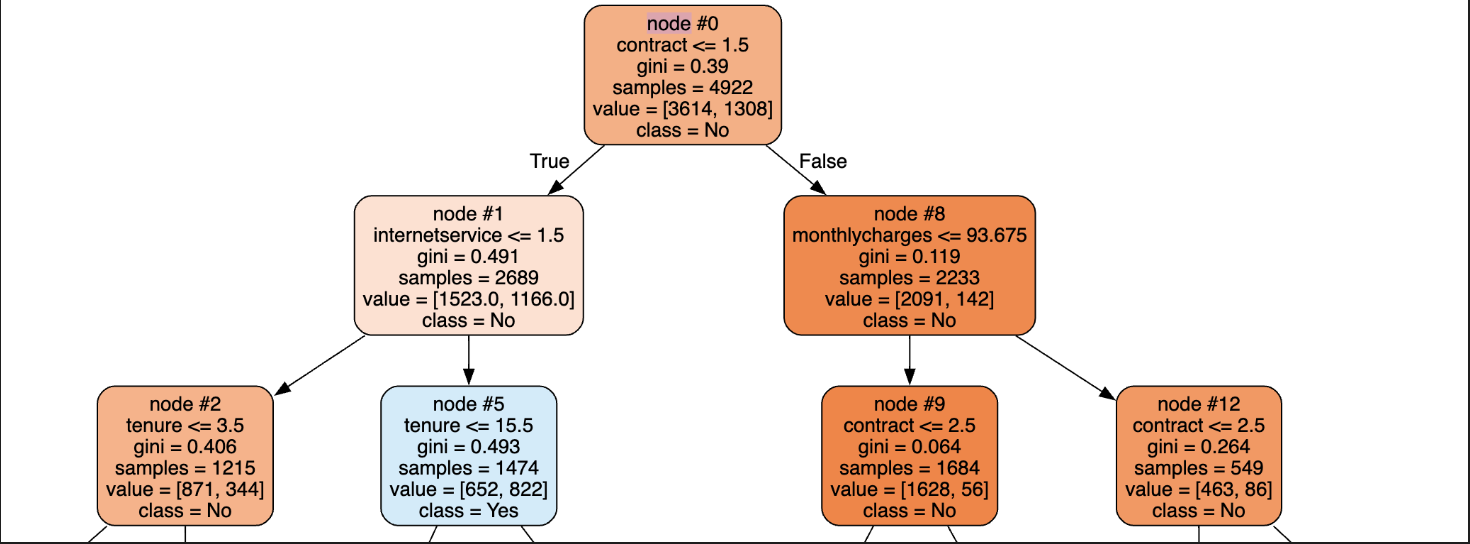

In [94]:
def plot_target(df, target=target, title=f"Distribution of target variable."):
    fig = px.sunburst(df, path=[target, "contract", "internetservice"], 
                    title=title,
                    color="contract",
                    width=500,
                    height=500)

    fig.update_traces(
        textinfo="label+percent parent+value",
        hovertemplate=None
    )
    fig.show()

In [95]:
plot_target(df)

So the inner circle here is our target variable, second is how long is a contract and the last one is internet service type

<h1>Start with TomekLinks</h1>

In [96]:
tomek = TomekLinks()

# X/y -split
X = df.drop(target, axis=1)
y = df[target]

# create new resampled versions of X and y
X_resampled, y_resampled = tomek.fit_resample(X, y)

# re-create a new DataFrame
df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled[target] = y_resampled

In [97]:
plot_target(df_resampled)

Found around 500 overlaps, not bad

<h1>Isolation forest</h1>

In [98]:
# Initialize isolation forest
iso = IsolationForest(contamination=0.07) 

# fit isolation forest
y_pred = iso.fit_predict(df_resampled)

# filter outliers only
outliers = df_resampled[y_pred != 1]
df_resampled = df_resampled.drop(outliers.index)

In [99]:
plot_target(df_resampled)

<h1>SMOTE+ENN</h1>
SMOTEENN is hybrid technique, basically SMOTE generates additional data and if ENN missclassify instance, it gets deleted

In [100]:
smoteenn = SMOTEENN(random_state=random_seed)

# X/y -split
X = df_resampled.drop(target, axis=1)
y = df_resampled[target]

X_resampled, y_resampled = smoteenn.fit_resample(X, y)

df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled[target] = y_resampled


<h1>Final comparison</h1>

In [101]:
plot_target(df_resampled, title="Resampled")
plot_target(df, title="Original")

!!! Plots are clickable, choose a class by clicking it, helps a lot !!!

If we compare positive churns we can see that distribution inside class didn't change that much. Contract class 1 is still dominating, few class 2 and even less class 3. There are some changes in distribution of intenet service class, but they are less than 10 percent points.

However, changes in negative churns are greater: contract class 1 (44% -> 25%), class 2 stays almost untouched and class 3 (31% -> 47%). But on the other side, composition of internet service inside classes stays approximately the same.

In [102]:
resampled_phik = df_resampled.phik_matrix()
resampled_descr = df_resampled.describe()
resampled_correlations = df_resampled.corr()

interval columns not set, guessing: ['seniorcitizen', 'tenure', 'multiplelines', 'internetservice', 'contract', 'paperlessbilling', 'monthlycharges', 'service_count', 'family', 'paymentmethod_Bank transfer (automatic)', 'paymentmethod_Credit card (automatic)', 'paymentmethod_Electronic check', 'churn']


In [103]:
fig = px.imshow(original_correlations, height=600,
                title="Original correlations")
fig.show()

In [104]:
fig = px.imshow(resampled_correlations, height=600,
                title="Resampled correlations")
fig.show()

In [105]:
fig = px.imshow(original_phik, height=600,
                title="Original phik matrix")
fig.show()

In [106]:
fig = px.imshow(resampled_phik, height=600,
                title="Resampled phik matrix")
fig.show()

On the heatmaps, both datasets follow same-ish trend (atleast colors are same-ish), but correlations and phik matrix are actually changing quite a bit, sometimes up to 2x times.


In [107]:
original_descr

,seniorcitizen,tenure,multiplelines,internetservice,contract,paperlessbilling,monthlycharges,churn,service_count,family,paymentmethod_Bank transfer (automatic),paymentmethod_Credit card (automatic),paymentmethod_Electronic check
count,6680.000000,6680.000000,6680.000000,6680.000000,6680.000000,6680.000000,6680.000000,6680.000000,6680.000000,6680.000000,6680.000000,6680.000000,6680.000000
mean,0.135629,31.706587,0.413174,1.214521,1.673653,0.598054,64.181100,0.250749,1.988772,0.534880,0.214521,0.202994,0.344012
std,0.342420,24.423403,0.492440,0.779240,0.829765,0.490328,29.886008,0.433476,1.818133,0.498819,0.410520,0.402258,0.475081
min,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,18.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,8.000000,0.000000,1.000000,1.000000,0.000000,35.137500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,27.500000,0.000000,1.000000,1.000000,1.000000,70.100000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,54.000000,1.000000,2.000000,2.000000,1.000000,89.450000,1.000000,3.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,72.000000,1.000000,2.000000,3.000000,1.000000,118.750000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000


In [108]:
resampled_descr

,seniorcitizen,tenure,multiplelines,internetservice,contract,paperlessbilling,monthlycharges,service_count,family,paymentmethod_Bank transfer (automatic),paymentmethod_Credit card (automatic),paymentmethod_Electronic check,churn
count,6519.000000,6519.000000,6519.000000,6519.000000,6519.000000,6519.000000,6519.000000,6519.000000,6519.000000,6519.000000,6519.000000,6519.000000,6519.000000
mean,0.084369,27.054916,0.399294,1.328425,1.545329,0.642123,66.852232,1.780641,0.427213,0.146341,0.141586,0.414174,0.562816
std,0.277961,24.573528,0.489791,0.772916,0.811693,0.479412,28.662772,1.723985,0.494712,0.353475,0.348652,0.492617,0.496076
min,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,18.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.000000,0.000000,1.000000,1.000000,0.000000,45.073477,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,19.000000,0.000000,2.000000,1.000000,1.000000,74.500000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,48.000000,1.000000,2.000000,2.000000,1.000000,89.650000,3.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,72.000000,1.000000,2.000000,3.000000,1.000000,118.750000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In description, everything is quite nice and changes are not so drastical. On the other hand most of the variables are ordinal or binary, so the change simply cannot be that big?

In [109]:
# X/y -split
X = df.drop(target, axis=1)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)


X_resampled = df_resampled.drop(target, axis=1)
y_resampled = df_resampled[target]
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=random_seed)

# Drop the original testing data from training set, so that can test on unseen data from original dataset
X_train_res.drop(X_test.index, inplace=True, errors="ignore")
y_train_res.drop(y_test.index, inplace=True, errors="ignore")

In [110]:
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [111]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [112]:
# evaluate predictions
print(classification_report(y_test, predictions))
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

              precision    recall  f1-score   support

           0       0.84      0.89      0.87       989
           1       0.63      0.53      0.57       347

    accuracy                           0.80      1336
   macro avg       0.74      0.71      0.72      1336
weighted avg       0.79      0.80      0.79      1336

Accuracy: 79.72%


In [113]:
model = XGBClassifier()
model.fit(X_train_res, y_train_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [114]:
y_pred = model.predict(X_test_res)
predictions = [round(value) for value in y_pred]

In [115]:
# evaluate predictions
print(classification_report(y_test_res, predictions))
accuracy = accuracy_score(y_test_res, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       559
           1       0.97      0.98      0.97       745

    accuracy                           0.97      1304
   macro avg       0.97      0.97      0.97      1304
weighted avg       0.97      0.97      0.97      1304

Accuracy: 96.70%


Yes, now we got perfect metrics for the resampled dataset, but let's try to test it on original data.

In [116]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [117]:
# evaluate predictions
print(classification_report(y_test, predictions))
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

              precision    recall  f1-score   support

           0       0.95      0.76      0.84       989
           1       0.56      0.89      0.69       347

    accuracy                           0.79      1336
   macro avg       0.76      0.82      0.77      1336
weighted avg       0.85      0.79      0.80      1336

Accuracy: 79.27%


I guess this testing method is not absolutely correct, because by deleting original test data from resampled dataset I reduce amount of training data, however he results were almost the same with and without this operation.

So, in the end of the day changing the distribution lead me to perfect metrics, but only on resampled data. As soon as I switch back to unseen original data result is potentially even worth. In this case, I suppose that company wants to predict the churn minority more then majority, and as a result I got better metrics on majority and worse on minority...